# Working with imbalanded classification data

Author: [Thomas Moreau](https://tommoral.github.io/) and [Alexandre Gramfort](https://alexandre.gramfort.net/)

In [1]:
# Global import
import numpy as np
import pandas as pd
from sklearn.base import clone
import matplotlib.pyplot as plt
from IPython.display import display, HTML

%matplotlib inline

For this notebook, we will need the imabalanced learn package (doc available here: https://imbalanced-learn.readthedocs.io/en/stable/index.html)

In [2]:
!pip install -U imbalanced-learn

  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


# The problem of class imbalanced in supervised classification

## Highlight the issue of working with imbalanced classes

To illustrate the issue of imbalance learn, we will use the `adult_census` dataset.  
A complete description of the data can be found [here](https://www.openml.org/d/1590). Basically, the task is to predict whether an individual will have an annual income of more than 50K dollars based on his personal information.

In [3]:
df = pd.read_csv("https://www.openml.org/data/get_csv/1595261/adult-census.csv")

In [4]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [5]:
display(HTML("<h3>Categorial variable</h3>"))
display(df.describe(exclude=np.number))
display(HTML("<h3>Numerical variable</h3>"))
display(df.describe(exclude=object))

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,class
count,48842,48842,48842,48842,48842,48842,48842,48842,48842
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,33906,15784,22379,6172,19716,41762,32650,43832,37155


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


We can analyze the target column, here called `class` which we will be using to train a model.

In [6]:
from collections import Counter

In [7]:
counter = Counter(df['class'])
counter

Counter({' <=50K': 37155, ' >50K': 11687})

By looking at the classes, we can observe that there is 2 classes: `' >50K'` and `' <=50K'`.
In addition, we can see that there is a difference regarding the classes frequencies. We can compute the balancing ratio.

In [8]:
counter[' <=50K'] / counter[' >50K']

3.179173440574998

We can check what it would imply if we are not careful when evaluating our model. We will train a `DummyClassifier` which will not predict by learning anything from the data but rather predict the most frequent class in the dataset.

In [9]:
# Get the data. We extract the labels
# We drop the fnlwgt feature which is not informative in
# this context (see data description for more info).
target_name = "class"
target = df[target_name].to_numpy()
data = df.drop(columns=[target_name, "fnlwgt"])

In [10]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(data, target)

DummyClassifier(strategy='most_frequent')

Let's verify that the classifier always outputs the most frequent class.

In [11]:
dummy_clf.predict([[0]])

array([' <=50K'], dtype='<U6')

In [12]:
y_pred = dummy_clf.predict(data)

Now, let's see what it implies regarding the default metric with scikit-learn classifier.

In [13]:
print(f"The accuracy of the most-frequent model is "
      f"{dummy_clf.score(data, target):.3f}")

The accuracy of the most-frequent model is 0.761


In [14]:
from sklearn.metrics import accuracy_score

In [15]:
print(f"The accuracy of the default model is "
      f"{accuracy_score(target, y_pred):.3f}")

The accuracy of the default model is 0.761


We can here see the main issue: **Unlike with balanced learning, the naive classification level is not `0.5`**.  
It is necessary to take into account the class unbalance to help the model learn something meaningful.

## Step 1: Use one or several informative metrics to detect the issue

Instead of using the `accuracy_score`, one could use the `balanced_accuracy_score`.

The `balanced_accuracy` avoids inflated performance estimates on imbalanced datasets:
* If the conventional accuracy is above chance only because the classifier takes advantage of an imbalanced test set, then the balanced accuracy, as appropriate, will drop to $\frac{1}{n_{classes}}$.
* If the classifier performs equally well on either class, this term reduces to the conventional accuracy (*i.e.*, the number of correct predictions divided by the total number of predictions).




*Details:* It is the raw accuracy where each sample is weighted according to the inverse prevalence of its true class. Given predicted $\widehat y_i$ for sample $i$, balanced accuracy is defined as:
$$
    \texttt{balanced-accuracy}(y, \widehat y) = \frac{1}{\sum w_i} \sum_i w_i 1\{\widehat y_i = y_i\}
$$
with $w_i = \frac{1}{\sum_j 1\{y_j = y_i\}}$, the frequency of class $y_i$ in the dataset.

In [16]:
from sklearn.metrics import balanced_accuracy_score

print(f"The balanced accuracy of the default model is "
      f"{balanced_accuracy_score(target, y_pred):.3f}")

The balanced accuracy of the default model is 0.500


Then, we can have a look at the confusion matrix to a real idea of what is happening.

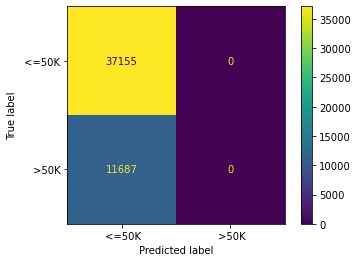

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(target, y_pred)

As we have seen in the first part of the lab, the confusion matrix can be summarized using several metrics

* precision and recall
* sensitivity and specificity
* area under the roc curve (ROC-AUC)

NB: sensitivity = recall
 
If we take as a positive class `' >50K'`, we get:

In [18]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision = precision_score(
    target, y_pred, pos_label=' >50K'
)
recall = recall_score(
    target, y_pred, pos_label=' >50K'
)

print(f"The recall of the dummy model is "
      f"{recall}")
print(f"The precision of the dummy model is "
      f"{precision}")

d:\Anaconda3\envs\ima\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The recall of the dummy model is 0.0
The precision of the dummy model is 0.0


In [19]:
from imblearn.metrics import sensitivity_score
from imblearn.metrics import specificity_score

sensitivity = sensitivity_score(
    target, y_pred, pos_label=' >50K')
specificity = specificity_score(
   target, y_pred, pos_label=' >50K')

print(f"The sensitivity of the dummy model is "
      f"{sensitivity}")
print(f"The specificity of the dummy model is "
      f"{specificity}")

The sensitivity of the dummy model is 0.0
The specificity of the dummy model is 1.0


## Step 2: How to solve the issue during `fit`

In this part, we will see how we can adapt the model to cope with imbalanced dataset.
First, we split the data in a train and a test set. Then we review various way to handle imbalanced data.

In [20]:
# split in train test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data, target, random_state=0
)

In [21]:
# Helper function to evaluate the different models
def evaluate_classifier(clf):
    name = getattr(clf, 'name', clf.__class__.__name__)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    y_pred = clf.predict(X_test)
    balanced_score = balanced_accuracy_score(y_test, y_pred)
    display(HTML(
        f"<h5>{name}</h5>"
        f"Test Accuracy: {score:7.2%} <br/>"
        f"Balanced accuracy: {balanced_score:7.2%} <br/>"
    ))

### 2.1 Baseline classifier

As we have seen before, we will compare the new classifiers with a dummy baseline which predict the most frequent label in the dataset. This baseline will highlight the improvement compared to naive strategies.

In [22]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.name = "Most Frequent Classifier"

evaluate_classifier(dummy_clf)

### 2.2 Make use of the `class_weight` parameter to modify the training cost

A first class of methods rely on sample weights to correct the imbalance. The core idea here is to weight prediction mistakes on the minority class higher than mistakes on the most common class.

#### In linear model - modifying the cost function

In `scikit-learn`, some estimators have a `class_weight` parameter that permits to do this. The idea is that the ERM is changed such that
$$
    \arg\min_\theta \frac{1}{\sum_i w_i} \sum_i w_i 1\{f_\theta(X_i) = y_i\}
$$
with weights $w_i = \frac{n}{kn_i}$ with $n$ the total number of samples, $k$ the number of classes and $n_i$ the number of samples from class $y_i$. This effectively rebalance the training in learning both from positive and negative examples.



In [23]:
binary_encoding_columns = ['sex']
one_hot_encoding_columns = [
    'workclass', 'education', 'marital-status',
    'occupation', 'relationship', 'race', 'native-country'
]
scaling_columns = [
    'age', 'education-num', 'hours-per-week',
    'capital-gain', 'capital-loss'
]

In [24]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

preprocessor_lr = ColumnTransformer([
    ('binary-encoder', OrdinalEncoder(), binary_encoding_columns),
    ('one-hot-encoder', OneHotEncoder(handle_unknown='ignore'),
     one_hot_encoding_columns),
    ('standard-scaler', StandardScaler(), scaling_columns)
])
model_lr = make_pipeline(
    preprocessor_lr,
    LogisticRegression(solver='lbfgs', max_iter=1000)
)
model_lr.name = "Logistic Regression" # aims to max test acc like banlanced data

In [25]:
evaluate_classifier(model_lr)

We can set the `class_weight='balanced'` uses the values of `y` to automatically adjust weights inversely proportional to class frequencies in the input data.

In [26]:
model_lr_balanced = clone(model_lr)
model_lr_balanced.set_params(
    logisticregression__class_weight='balanced')
model_lr_balanced.name = "Logistic Regression with balanced weights"
evaluate_classifier(model_lr_balanced)

#### In tree-based model - modifying the purity criterion

In tree based models, the `class_weight` option is used to chose on the splits. Indeed, the purity criterion (which is minimize for to chose the split) is computed using these weights. In the leaf, the weights are used to compute the class to output.

In [27]:
ordinal_encoding_columns = ['workclass', 'education', 'marital-status',
                            'occupation', 'relationship', 'sex',
                            'race', 'native-country']
scaling_columns = ['age', 'education-num', 'hours-per-week',
                   'capital-gain', 'capital-loss']

In [28]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier

preprocessor_rf = ColumnTransformer([
    ('ordinal-encoder', OrdinalEncoder(), ordinal_encoding_columns),
    ('standard-scaler', FunctionTransformer(validate=False), scaling_columns)
])
model_rf = make_pipeline(
    preprocessor_rf,
    RandomForestClassifier(n_estimators=100, random_state=42)
)
model_rf.name = "Random Forest"

In [29]:
evaluate_classifier(model_rf)

In [30]:
model_rf_balanced = clone(model_rf)
model_rf_balanced.set_params(
    randomforestclassifier__class_weight='balanced' # modify the purity
)
model_rf_balanced.name = "Balanced Random Forest"

evaluate_classifier(model_rf_balanced)

For ensemble models, `class_weight` can also take value `balanced_subsample`. This option is equivalent to the `'balanced'` one except that the weigths are computed directly for the bootstrap sample of each tree instead of weights computed globally.

In [31]:
model_rf_subbalanced = clone(model_rf)
model_rf_subbalanced.set_params(
    randomforestclassifier__class_weight='balanced_subsample'
)
model_rf_subbalanced.name = "Balanced Subsample Random Forest"

evaluate_classifier(model_rf_subbalanced)

### 2.3 Resample the training set to have balanced classes

A second option to learn on unbalanced data is to reweight the classes by sampling a new training set with balanced class. This can be done by either subsampling, oversampling or more complicated scheme demonstrated in this section.

#### Random under-sampling during training

In [32]:
from imblearn.pipeline import make_pipeline as make_pipeline_imblearn
from imblearn.under_sampling import RandomUnderSampler

In [33]:
model_lr_undersampled = make_pipeline_imblearn(
    preprocessor_lr,
    RandomUnderSampler(),
    LogisticRegression(solver='lbfgs', max_iter=1000)
)
model_lr_undersampled.name = "Logistic Regression from rebalanced undersampled data"

In [34]:
evaluate_classifier(model_lr_undersampled)

works only not too unbalanced

#### Random over-sampling during training

In [35]:
from imblearn.over_sampling import RandomOverSampler

In [36]:
model_lr_oversampled = make_pipeline_imblearn(
    preprocessor_lr,
    RandomOverSampler(),
    LogisticRegression(solver='lbfgs', max_iter=1000)
)
model_lr_oversampled.name = "Logistic Regression from rebalanced oversampled data"

In [37]:
evaluate_classifier(model_lr_oversampled)

#### More fancy methods


There exists some more fancy methods to re-balance the dataset. For instance the SMOTE method where extra points are generated by creatinig synthetic points for the minority class. See more info on the [original paper](https://arxiv.org/pdf/1106.1813.pdf) or in this [blog post](http://rikunert.com/SMOTE_explained).

In [38]:
from imblearn.over_sampling import SMOTE

In [39]:
model_lr_smote = make_pipeline_imblearn(
    preprocessor_lr,
    SMOTE(),
    LogisticRegression(solver='lbfgs', max_iter=1000)
)
model_lr_smote.name = "Logistic Regression from SMOTE sampled data"

In [40]:
evaluate_classifier(model_lr_smote)

You can look in [imbalanced-learn documentation](https://imbalanced-learn.org/stable/references/over_sampling.html) for more sampling strategies.

### 2.4 Used balanced algorithms: `BalancedRandomForest` and `BalancedBaggingClassifier` 

Instead of just sampling the training set to rebalance the classes, it is also possible to used _balanced_ classifier to fit the unbalanced dataset. The core idea is to use ensemble techniques with specific boostrap sampling strategies that make sure that each bootstrap sample is balanced.

#### Example of `BalancedRandomForestClassifier`

Here, a random forest is learn on the full dataset. Each tree is constructed using a balanced sub-sampled of the dataset.  
This idea has been proposed by [Chen et al. (2004)](https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf).

In [41]:
from imblearn.ensemble import BalancedRandomForestClassifier

model_balanced_rf = make_pipeline(
    preprocessor_rf,
    BalancedRandomForestClassifier(
        n_estimators=100, random_state=42
    )
)
model_balanced_rf.name = "Balanced Random Forest"

In [42]:
evaluate_classifier(model_balanced_rf)

#### Example of `BalancedBaggingClassifier`

In ensemble classifiers, bagging methods build several estimators on different randomly selected subset of data. In scikit-learn, this classifier is named `BaggingClassifier`. However, this classifier does not allow to balance each subset of data. Therefore, when training on imbalanced data set, this classifier will favor the majority classes.

In [43]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

In [44]:
model_bagging = make_pipeline(
    preprocessor_rf,
    BaggingClassifier(
        base_estimator=HistGradientBoostingClassifier(),
        n_estimators=10, random_state=42
    )
)
model_bagging.name = "Bagging Model"

In [45]:
evaluate_classifier(model_bagging)

`BalancedBaggingClassifier `allows to resample each subset of data before to train each estimator of the ensemble. In short, it combines the output of an `EasyEnsemble` sampler with an ensemble of classifiers (i.e. `BaggingClassifier`). Therefore, `BalancedBaggingClassifier `takes the same parameters than the scikit-learn `BaggingClassifier`. Additionally, there is two additional parameters, sampling_strategy and replacement to control the behaviour of the random under-sampler.

In [46]:
from imblearn.ensemble import BalancedBaggingClassifier
model_balanced_bagging = make_pipeline(
    preprocessor_rf,
    BalancedBaggingClassifier(
        estimator=HistGradientBoostingClassifier(),
        n_estimators=10, random_state=42
    )
)
model_balanced_bagging.name = "Balanced Bagging Model"

In [47]:
evaluate_classifier(model_balanced_bagging)